In [17]:
import warnings
warnings.filterwarnings('ignore')
# Hide input cells in Jupyter Notebook
from IPython.display import display, HTML

display(HTML("<style>.jp-InputArea { display: None !important; }</style>"))


In [1]:
import numpy as np
import pandas as pd

file_path = '/home/shiftpub/AMM-Python/results/dummy_results/sp500_simulation_result_second.csv'
results = pd.read_csv(file_path)
unique_fee_rate = results['fee_rate'].unique()



| **Parameter**            | **Value**                                                                 |
|--------------------------|---------------------------------------------------------------------------|
| **Initial Token A**       | 1,000,000 units (1 million)                                               |
| **Initial Token B**       | 1,000,000 units (1 million)                                               |
| **Fee Rate**              | `np.round(np.arange(0.0005, 0.02, 0.0005), 4)`  |
| **Sigma (Volatility)**    | `np.round(np.arange(0.05, 0.35, 0.05), 3)`  |
| **Time Interval (dt)**    | `1/(252*6.5*3600)` (second interval)                                      |
| **Simulation Length**     | 468,000 steps (20 trading days)                                                      |
| **Market Spread**         | 0.05                                                                     |
| **Drift Rate**            | 0.06                                                                   |
| **Start Price (Token A, B)** | 500                                                                 |
| **Iterations per Combination** | 300 (for each combination of `sigma` and `fee rate`)                |



### Plan:

    I. Demonstrate the overall relationship between sigmas and fee collected in AMM.

    II. Explore the Max Mean fee rate for each sigma.

    III. Examine the pattern between sigma and Max Mean fee rate. 



ValueError: List of boxplot statistics and `positions` values must have same the length

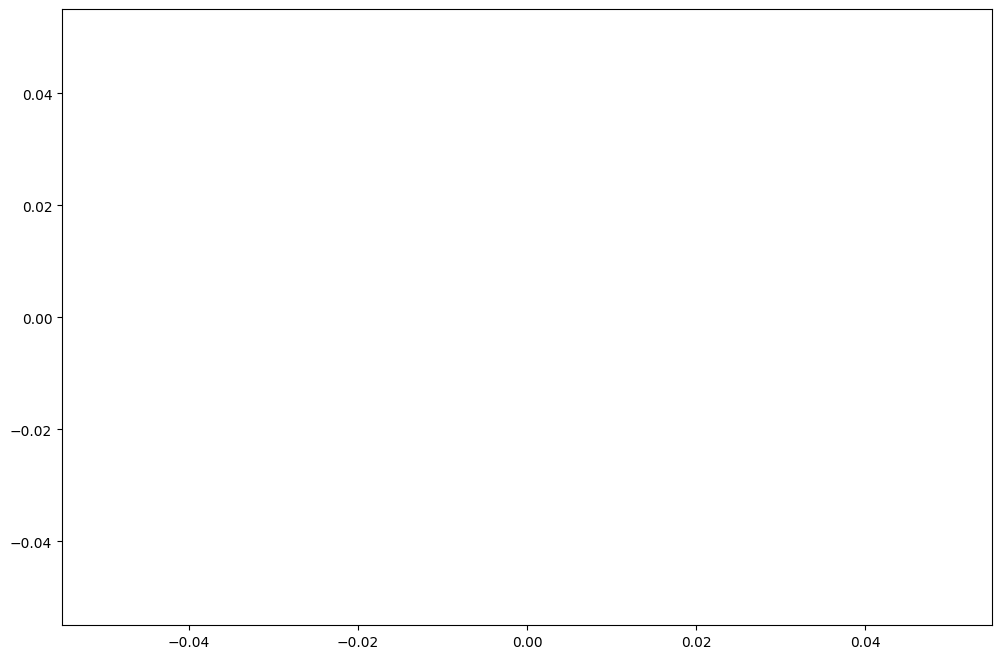

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the plot
plt.figure(figsize=(12, 8))

# Draw the boxplot
sns.boxplot(x='sigma', y='fee', data=results)

# rotate the x-axis labels
plt.xticks(rotation=45)
# Set the labels and title
plt.xlabel('Sigma')
plt.ylabel('Fee')
plt.title('Distribution of Fees for Different Sigma Values')

# Show the plot
plt.show()



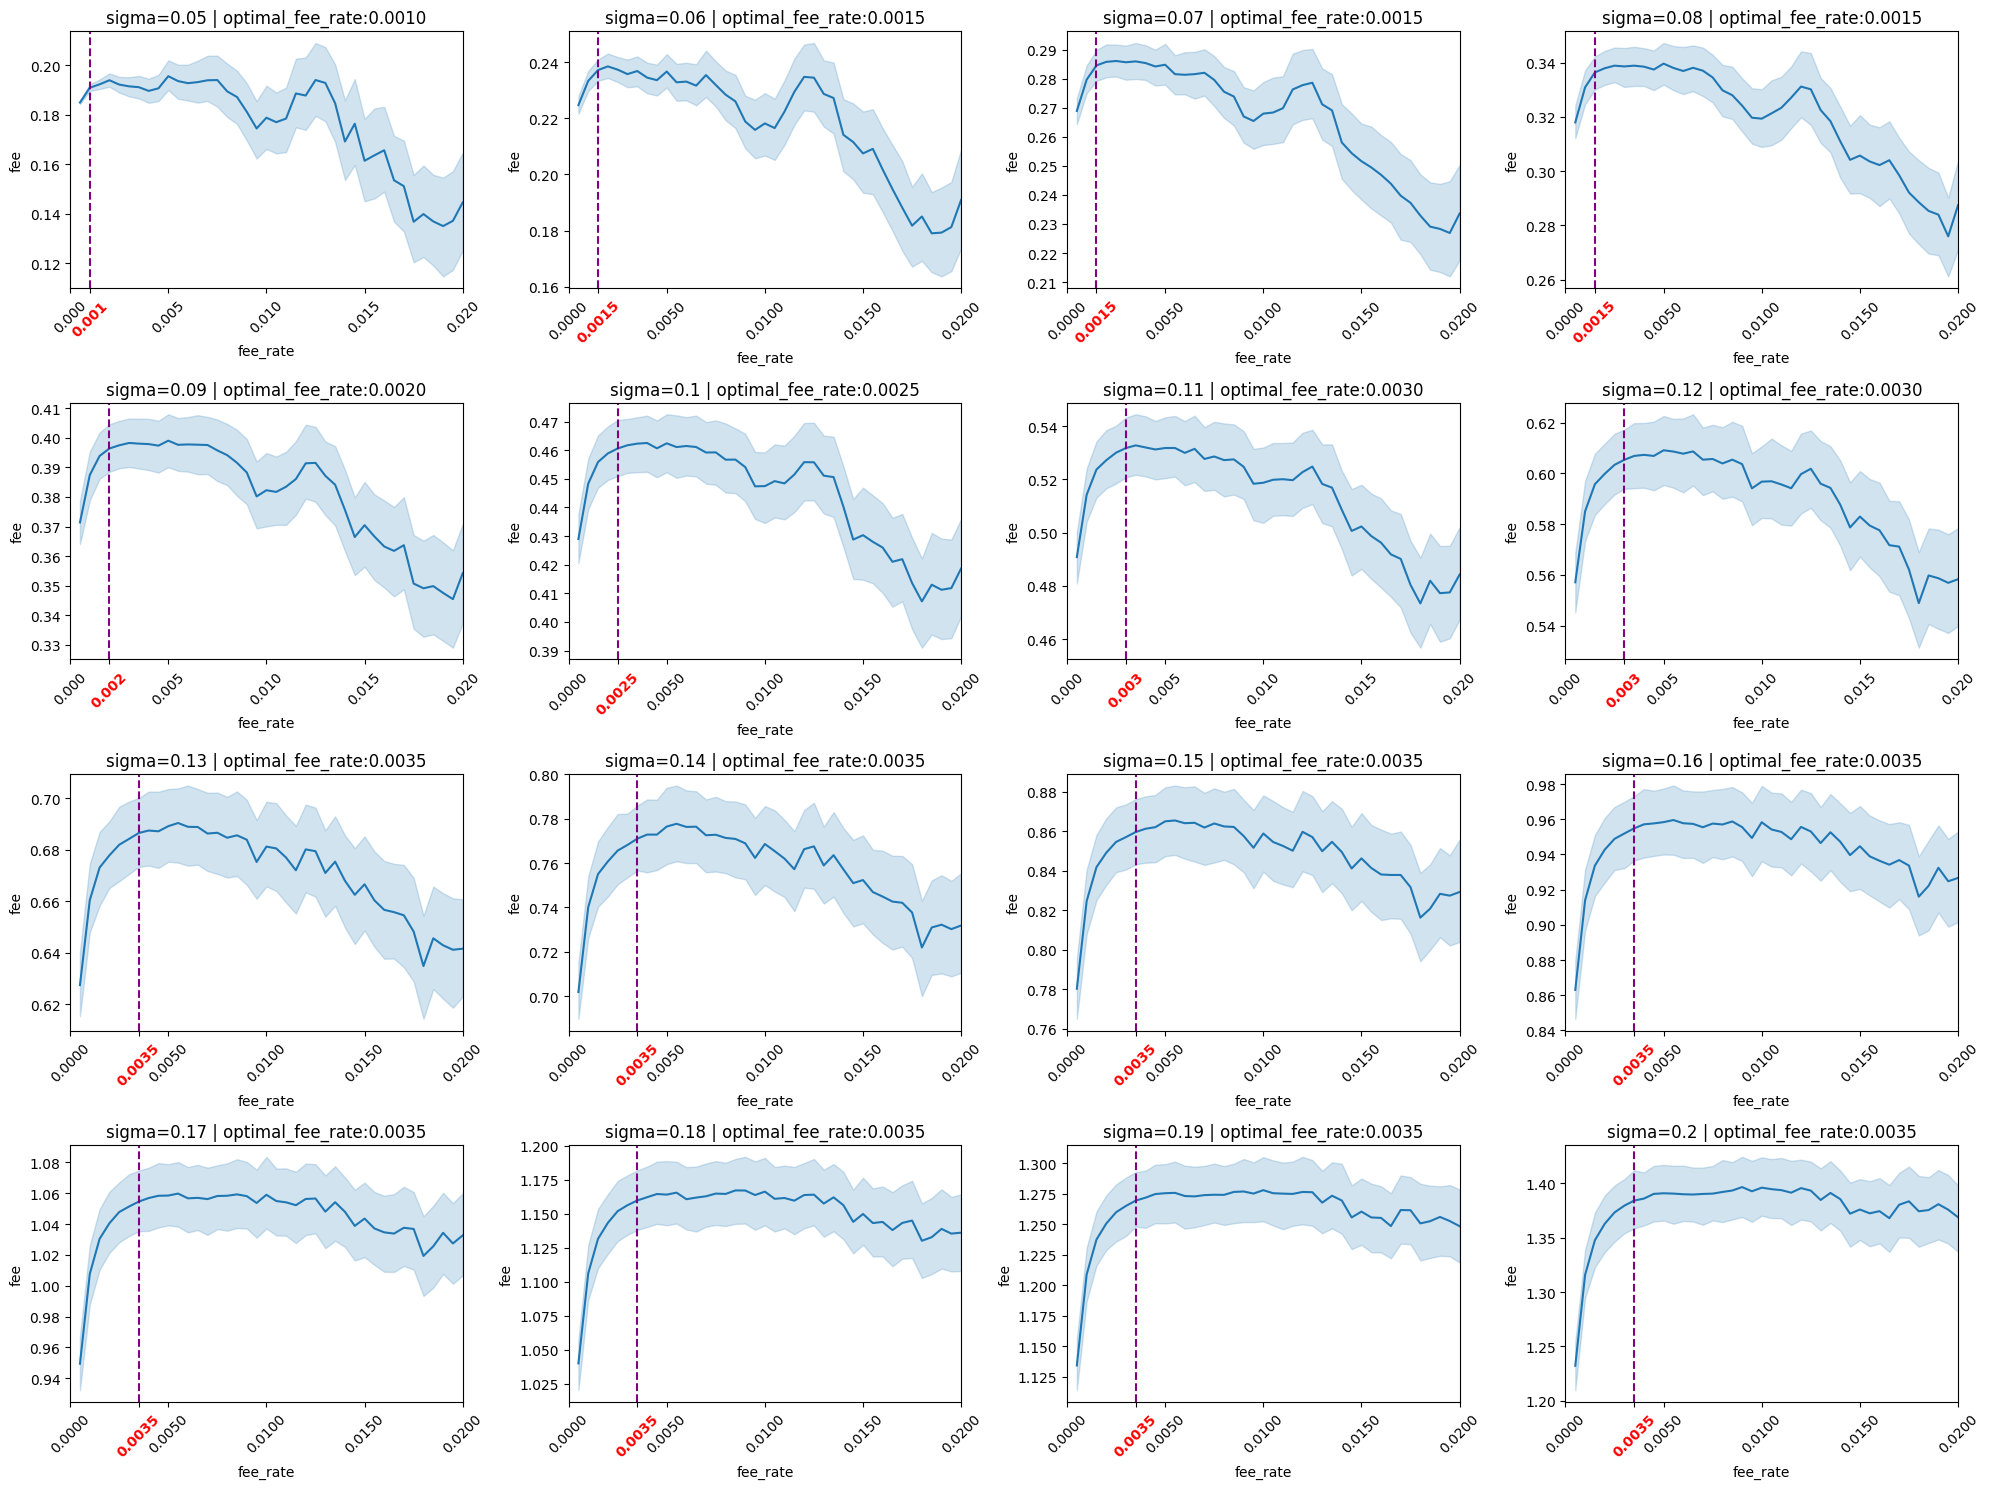

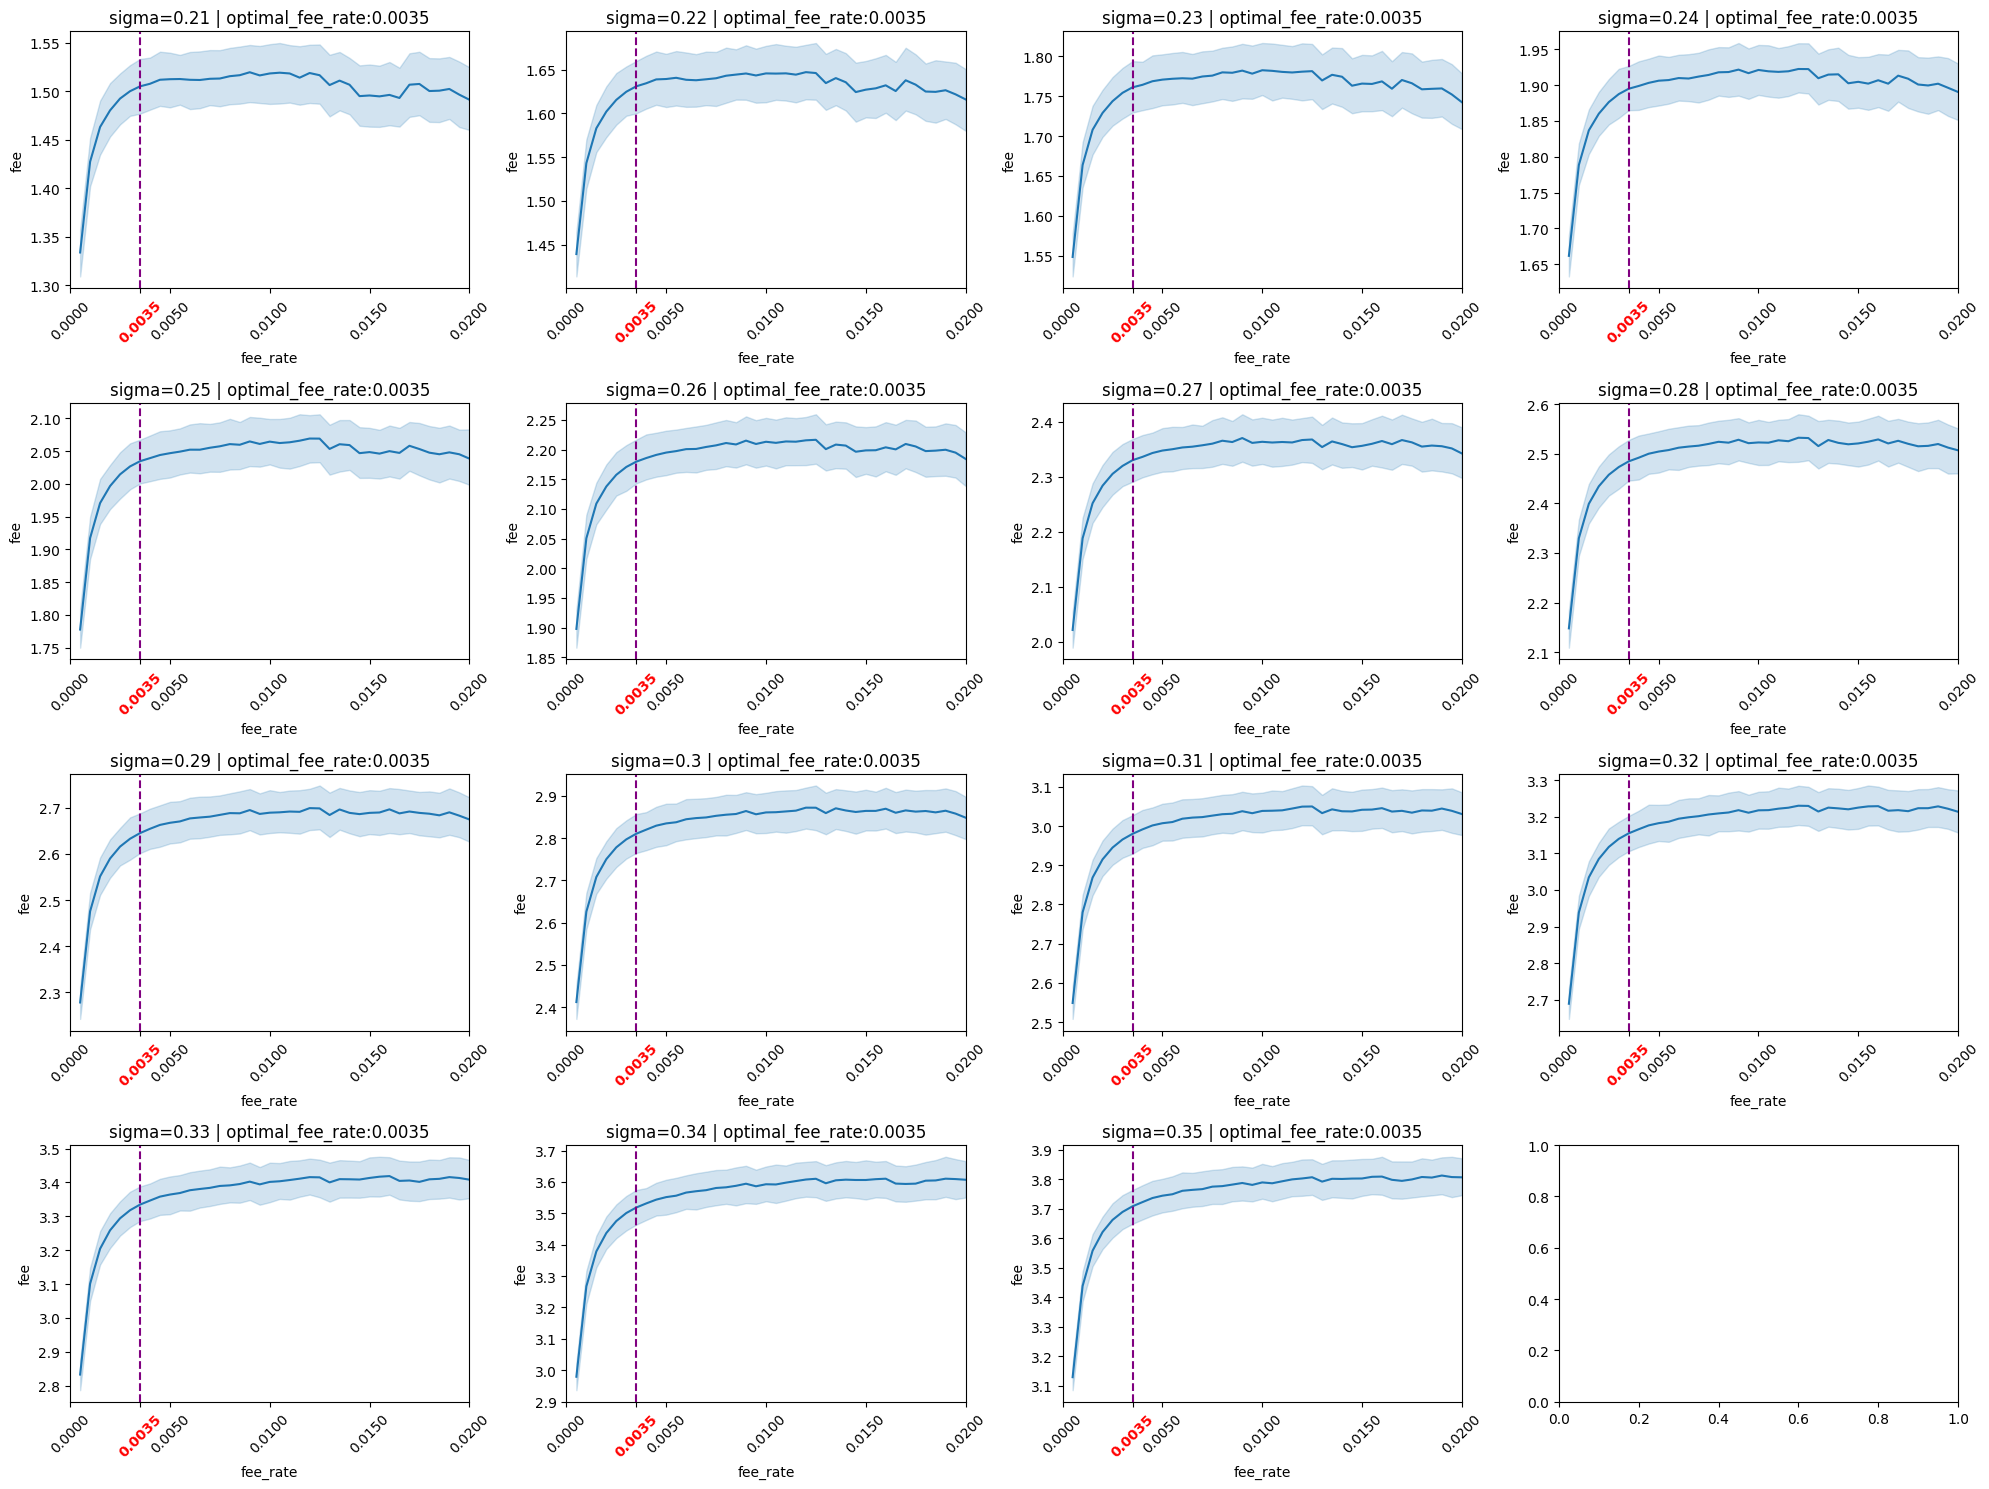

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def kneedle(x, y, S=1.0):
    """
    Implementation of the Kneedle algorithm to find the elbow point.
    :param x: Array of x values (e.g., fee rates).
    :param y: Array of y values (e.g., mean fees).
    :param S: Sensitivity parameter to adjust the sensitivity of the algorithm.
    :return: The x value (fee rate) at the elbow point.
    """
    # Normalize x and y values
    x_norm = (x - x.min()) / (x.max() - x.min())
    y_norm = (y - y.min()) / (y.max() - y.min())
    
    # Calculate the difference between the normalized y and the diagonal line
    diff = y_norm - x_norm
    
    # Find the point with the maximum curvature (elbow point)
    elbow_idx = np.argmax(diff)
    elbow_x = x[elbow_idx]
    
    return elbow_x

# Unique sigma values
unique_sigma = results['sigma'].unique()

# Set chunk size for plots (16 per chunk)
chunk_size = 16

# Split unique sigma values into chunks of the specified size
chunks = [unique_sigma[i:i + chunk_size] for i in range(0, len(unique_sigma), chunk_size)]

# Iterate through each chunk to create separate figures
for chunk_idx, chunk in enumerate(chunks):
    # Define the number of rows and columns for the subplots grid
    num_cols = 4
    num_rows = 4

    # Create subplots for this chunk
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 15))
    axes = axes.flatten()  # Flatten the axes for easy iteration

    # Loop through each sigma value in the current chunk and create a subplot
    for i, sigma in enumerate(chunk):
        df = results[results['sigma'] == sigma].copy()  # Filter for the current sigma
        
        # Group by fee_rate and calculate mean fee
        grouped = df.groupby('fee_rate')['fee'].mean().reset_index()
        
        # Extract fee rates and mean fees
        fee_rates = grouped['fee_rate'].values
        mean_fees = grouped['fee'].values
        
        # Apply the Kneedle algorithm to find the elbow point
        optimal_fee_rate = kneedle(fee_rates, mean_fees)
        
        # Plot the mean fee vs fee_rate
        sns.lineplot(x='fee_rate', y='fee', data=df, ax=axes[i])
        
        # Add a dashed line to indicate the elbow point
        axes[i].axvline(x=optimal_fee_rate, color='purple', linestyle='--')
        
        # Set labels and title
        axes[i].set_xlabel('fee_rate')
        axes[i].set_ylabel('fee')
        axes[i].tick_params(axis='x', rotation=45)
        axes[i].set_title(f'sigma={sigma} | optimal_fee_rate:{optimal_fee_rate:.4f}')
        
        # Get the current tick locations and add the optimal fee rate if it's not already present
        xticks = list(axes[i].get_xticks())
        if optimal_fee_rate not in xticks:
            xticks.append(optimal_fee_rate)  # Add the optimal fee rate to the tick locations
            xticks = sorted(xticks)  # Sort the ticks
        
        axes[i].set_xticks(xticks)  # Update the ticks on the x-axis
        
        # set x axis lim from 0 to 0.02
        axes[i].set_xlim(left=0)
        axes[i].set_xlim(right=0.02)
        
        # Highlight the x-tick that corresponds to the optimal fee rate
        xtick_labels = axes[i].get_xticklabels()
        for label in xtick_labels:
            try:
                tick_value = float(label.get_text())
                if abs(tick_value - optimal_fee_rate) < 1e-5:  # Checking if the tick corresponds to the optimal fee rate
                    label.set_color('red')
                    label.set_fontweight('bold')
            except ValueError:
                continue  # Skip labels that cannot be converted to float

        axes[i].set_xticklabels(xtick_labels)

    # Adjust layout and show the figure
    plt.tight_layout()
    plt.show()


### Linear Regression : Max Mean fee rate VS. Sigma

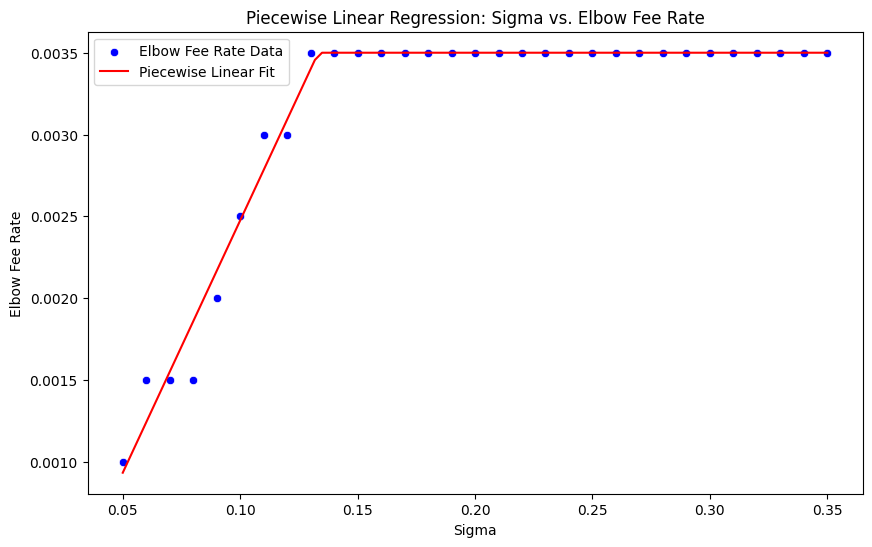

Fitted parameters:
x0 (transition point): 0.13324324338122795
y0 (initial value): -0.0006083333375586515
k1 (slope of the first segment): 0.03083333337880471
k2 (slope of the second segment): -5.379119089541748e-11


In [44]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import seaborn as sns

# List to store sigma and corresponding fee_rate with highest mean fee
sigma_values = []
max_fee_rates = []

# Loop through each sigma
for sigma in unique_sigma:
    df = results[results['sigma'] == sigma].copy()  # Filter the dataframe for current sigma
    
    # Calculate the fee_rate with the highest mean fee for this sigma
    max_fee_rate = df.groupby('fee_rate')['fee'].mean().idxmax()
    
    # Store the sigma and the corresponding max fee_rate
    sigma_values.append(sigma)
    max_fee_rates.append(max_fee_rate)

# Prepare the data (assuming you already have sigma_values and max_fee_rates lists)
plot_data = pd.DataFrame({'sigma': sigma_values, 'max_fee_rate': max_fee_rates})

# Features and target
X = plot_data[['sigma']]  # Independent variable
y = plot_data['max_fee_rate']  # Dependent variable

# Define a piecewise function
def piecewise_linear(x, x0, y0, k1, k2):
    return np.where(x < x0, k1 * x + y0, k2 * (x - x0) + (k1 * x0 + y0))

# Fit the piecewise model
x_data = plot_data['sigma'].values
y_data = plot_data['elbow_fee_rate'].values

# Initial guess for parameters: (x0, y0, k1, k2)
initial_guess = [0.1, 0.001, 0.01, 0]

# Fit the model using curve_fit
params, _ = curve_fit(piecewise_linear, x_data, y_data, p0=initial_guess)

# Extract the parameters
x0, y0, k1, k2 = params

# Generate predictions
x_fit = np.linspace(min(x_data), max(x_data), 100)
y_fit = piecewise_linear(x_fit, *params)

# Plot the data and the fitted model
plt.figure(figsize=(10, 6))
sns.scatterplot(x='sigma', y='elbow_fee_rate', data=plot_data, color='blue', label='Elbow Fee Rate Data')
plt.plot(x_fit, y_fit, color='red', label='Piecewise Linear Fit')
plt.xlabel('Sigma')
plt.ylabel('Elbow Fee Rate')
plt.title('Piecewise Linear Regression: Sigma vs. Elbow Fee Rate')
plt.legend()
plt.show()

# Print the fitted parameters
print("Fitted parameters:")
print(f"x0 (transition point): {x0}")
print(f"y0 (initial value): {y0}")
print(f"k1 (slope of the first segment): {k1}")
print(f"k2 (slope of the second segment): {k2}")


In [25]:
# download SP500 daily data in from 2020-01-01 to 2024-10-01 from yahoo finance
import yfinance as yf
import pandas as pd

# Download SP500 data from Yahoo Finance
spy = yf.download('SPY', start='2020-01-01', end='2024-10-01')


[*********************100%***********************]  1 of 1 completed


In [28]:
# calculate the daily returns and volatility
spy['daily_return'] = spy['Adj Close'].pct_change()
spy['volatility'] = spy['daily_return'].rolling(window=20).std()
spy['annualized_volatility'] = spy['volatility'] * (252 ** 0.5)

Text(0.5, 1.0, 'Distribution of Annualized Volatility for SPY (2020-2024)')

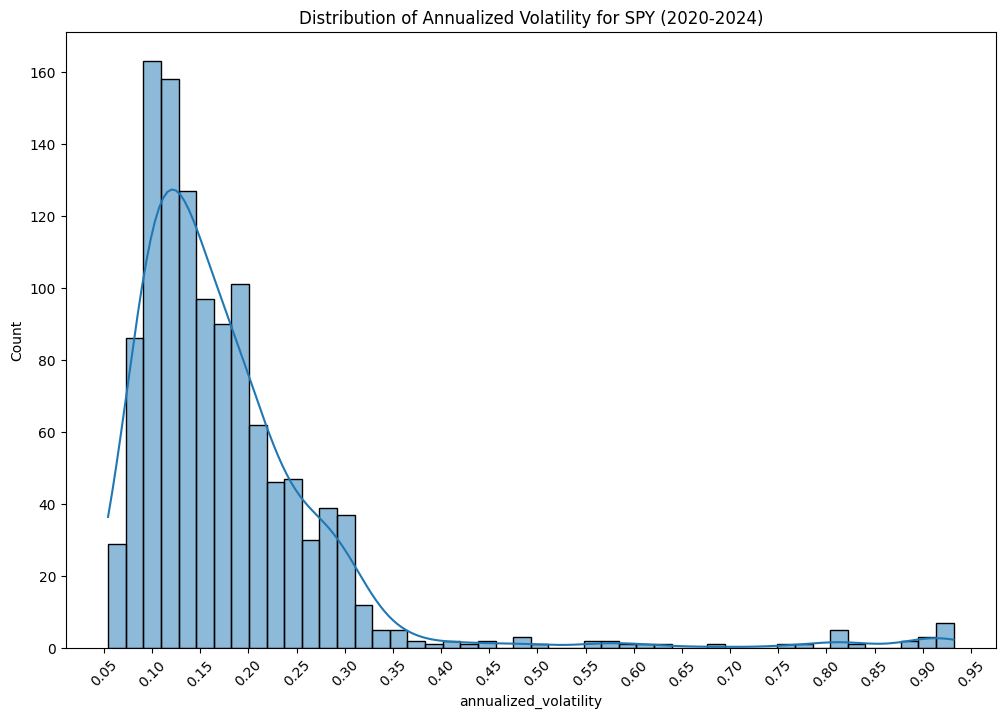

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns   
# draw a histogram of the annualized volatility
plt.figure(figsize=(12, 8))
sns.histplot(spy['annualized_volatility'].dropna(), kde=True)
plt.xticks(rotation=45)
# increase number of ticks on x-axis
plt.locator_params(axis='x', nbins=20)
plt.title('Distribution of Annualized Volatility for SPY (2020-2024)')

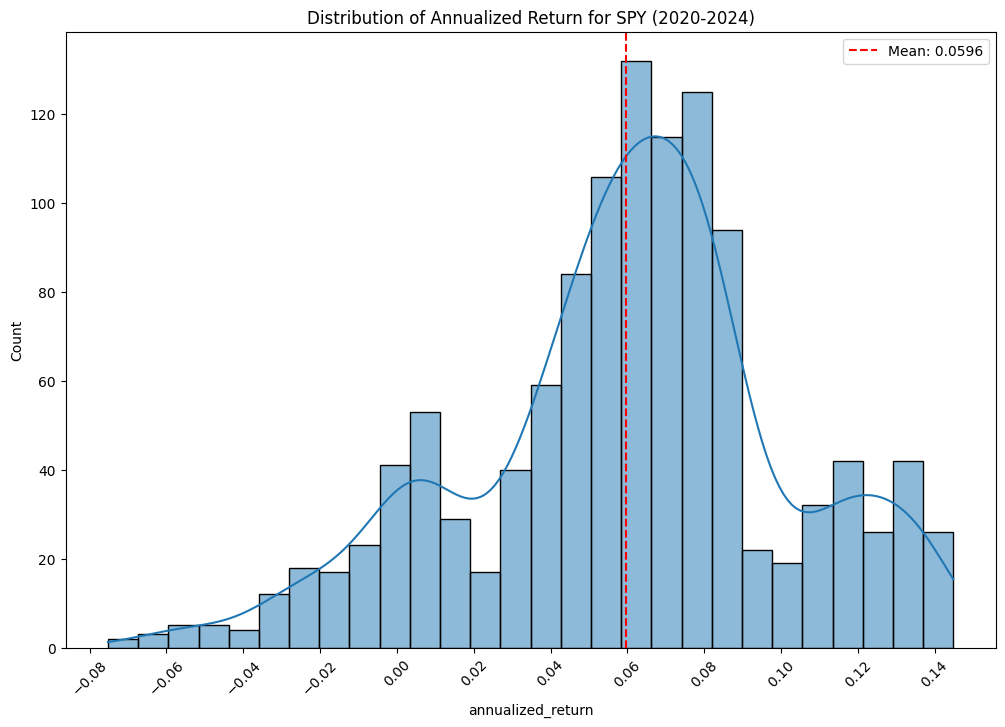

In [30]:
# calculate the anualized return
spy['annualized_return'] = (1 + spy['daily_return']).cumprod() ** (252 / len(spy)) - 1

# draw a histogram of the annualized return
plt.figure(figsize=(12, 8))
sns.histplot(spy['annualized_return'].dropna(), kde=True)
plt.xticks(rotation=45)
# increase number of ticks on x-axis
plt.locator_params(axis='x', nbins=20)
plt.title('Distribution of Annualized Return for SPY (2020-2024)')
# add a vertical line on the mean and write it in the legend
plt.axvline(spy['annualized_return'].mean(), color='red', linestyle='--', label=f'Mean: {spy["annualized_return"].mean():.4f}')
plt.legend()    

plt.show()



In [50]:
from arch import arch_model
import yfinance as yf
import numpy as np
import pandas as pd

# Download SPY data
spy = yf.download('SPY', start='2020-01-01', end='2024-10-01')

# Calculate log returns
spy['Log_Returns'] = np.log(spy['Adj Close'] / spy['Adj Close'].shift(1))
spy = spy.dropna()

# Iterate over different combinations of p and q
best_aic = np.inf  # Initialize with a high value
best_order = None
best_model = None

for p in range(1, 4):
    for q in range(1, 4):
        try:
            model = arch_model(spy['Log_Returns'], vol='Garch', p=p, q=q)
            model_fit = model.fit(disp='off')
            aic = model_fit.aic
            if aic < best_aic:
                best_aic = aic
                best_order = (p, q)
                best_model = model_fit
        except Exception as e:
            print(f"Model GARCH({p},{q}) failed with error: {e}")

print(f"Best model order: GARCH{best_order} with AIC: {best_aic}")
print(best_model.summary())


[*********************100%***********************]  1 of 1 completed

Best model order: GARCH(2, 2) with AIC: -7475.833934128676
                     Constant Mean - GARCH Model Results                      
Dep. Variable:            Log_Returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                3743.92
Distribution:                  Normal   AIC:                          -7475.83
Method:            Maximum Likelihood   BIC:                          -7445.33
                                        No. Observations:                 1193
Date:                Tue, Oct 08 2024   Df Residuals:                     1192
Time:                        13:07:31   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------

[*********************100%***********************]  1 of 1 completed

                     Constant Mean - GARCH Model Results                      
Dep. Variable:            Log_Returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                3743.92
Distribution:                  Normal   AIC:                          -7475.83
Method:            Maximum Likelihood   BIC:                          -7445.33
                                        No. Observations:                 1193
Date:                Tue, Oct 08 2024   Df Residuals:                     1192
Time:                        13:08:47   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         8.3563e-04  4.003e-04      2.087  3.685e-02 [5.

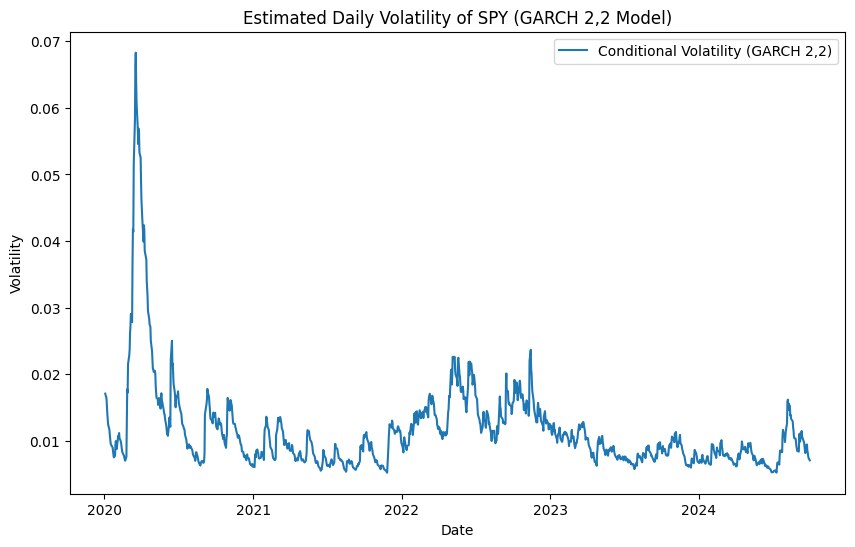


Trained GARCH(2,2) Parameters:
alpha0 (omega): 3.6495997020763665e-06
alpha1 (alpha[1]): 0.09999989631275566
alpha2 (alpha[2]): 0.09999987518264385
beta1 (beta[1]): 0.39000083805952757
beta2 (beta[2]): 0.38999949273198525


In [51]:
import yfinance as yf
import pandas as pd
import numpy as np
from arch import arch_model
import matplotlib.pyplot as plt

# Step 1: Download SPY daily data using yfinance
spy = yf.download('SPY', start='2020-01-01', end='2024-10-01')

# Step 2: Calculate the daily log returns
spy['Log_Returns'] = np.log(spy['Adj Close'] / spy['Adj Close'].shift(1))

# Step 3: Drop any missing values (e.g., from the shift operation)
spy = spy.dropna()

# Step 4: Fit a GARCH(2,2) model to the log returns
model = arch_model(spy['Log_Returns'], vol='Garch', p=2, q=2)
garch_fit = model.fit(disp='off')

# Step 5: Print the summary of the model fit
print(garch_fit.summary())

# Step 6: Plot the conditional volatility (standard deviation) over time
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(garch_fit.conditional_volatility, label='Conditional Volatility (GARCH 2,2)')
ax.set_title('Estimated Daily Volatility of SPY (GARCH 2,2 Model)')
ax.set_xlabel('Date')
ax.set_ylabel('Volatility')
plt.legend()
plt.show()

# Optional: Save the fitted parameters for later use
params = garch_fit.params
alpha0 = params['omega']
alpha1 = params['alpha[1]']
alpha2 = params['alpha[2]']
beta1 = params['beta[1]']
beta2 = params['beta[2]']

print(f"\nTrained GARCH(2,2) Parameters:")
print(f"alpha0 (omega): {alpha0}")
print(f"alpha1 (alpha[1]): {alpha1}")
print(f"alpha2 (alpha[2]): {alpha2}")
print(f"beta1 (beta[1]): {beta1}")
print(f"beta2 (beta[2]): {beta2}")


Index(['sigma', 'fee_rate', 'pnl', 'fee', 'volume', 'estimated_sigma'], dtype='object')


In [2]:
print(results.head())

   sigma  fee_rate         pnl       fee  volume  estimated_sigma
0    NaN    0.0005  262.209682  3.167341  468000         0.153291
1    NaN    0.0005  274.520929  3.174936  468000         0.153920
2    NaN    0.0005  273.932726  3.141884  468000         0.154327
3    NaN    0.0005  257.751841  3.115040  468000         0.154104
4    NaN    0.0005  262.264777  3.098007  468000         0.153827


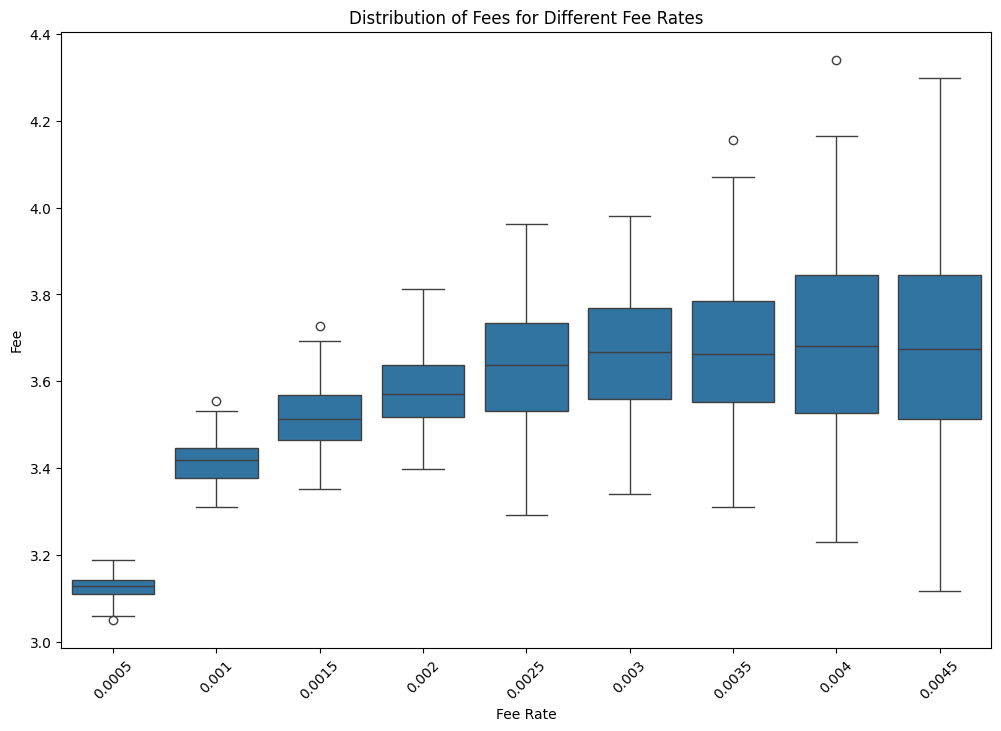

In [6]:
# draw boxplot of fee for different fee rates
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

file_path = '/home/shiftpub/AMM-Python/results/dummy_results/sp500_simulation_result_second_with_random_volatility.csv'
results = pd.read_csv(file_path)
unique_fee_rate = results['fee_rate'].unique()
print(results.columns)
# Set up the plot
plt.figure(figsize=(12, 8))

# Draw the boxplot
sns.boxplot(x='fee_rate', y='fee', data=results)

# rotate the x-axis labels
plt.xticks(rotation=45)
# Set the labels and title
plt.xlabel('Fee Rate')
plt.ylabel('Fee')
plt.title('Distribution of Fees for Different Fee Rates')

# Show the plot
plt.show()


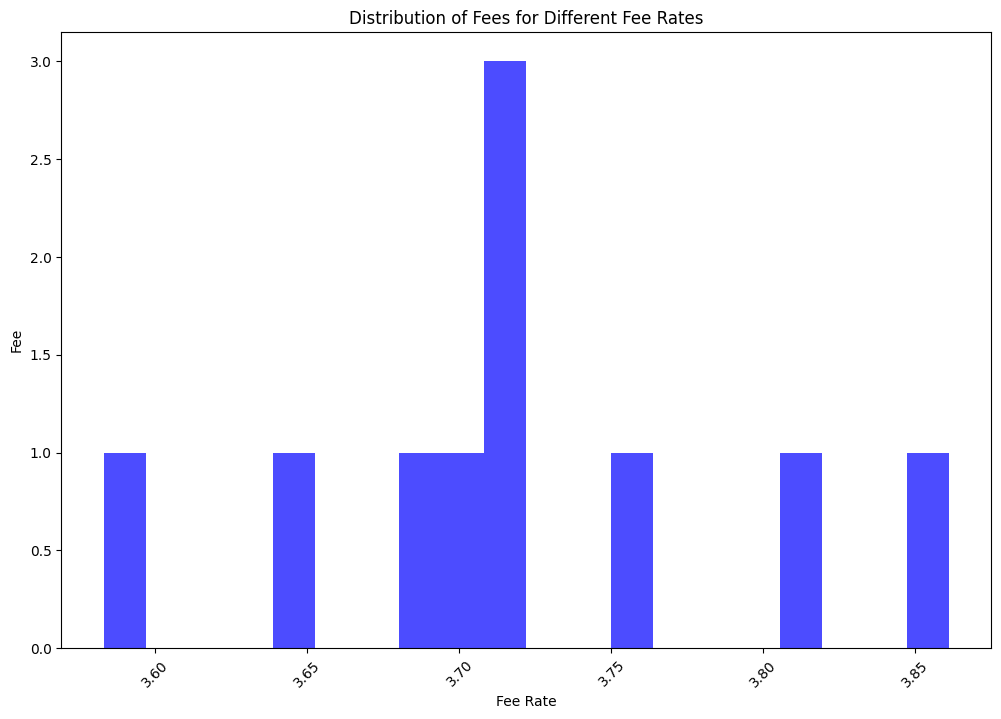

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

file_path = '/home/shiftpub/AMM-Python/results/dummy_results/sp500_simulation_result_dynamic_fee_rate.csv'
results = pd.read_csv(file_path)

# Set up the plot
plt.figure(figsize=(12, 8))

# Draw the boxplot
# sns.boxplot(x='fee_rate', y='fee', data=results)
plt.hist(results['fee'], bins=20, color='blue', alpha=0.7)
# rotate the x-axis labels
plt.xticks(rotation=45)
# Set the labels and title
plt.xlabel('Fee Rate')
plt.ylabel('Fee')
plt.title('Distribution of Fees for Different Fee Rates')

# Show the plot
plt.show()


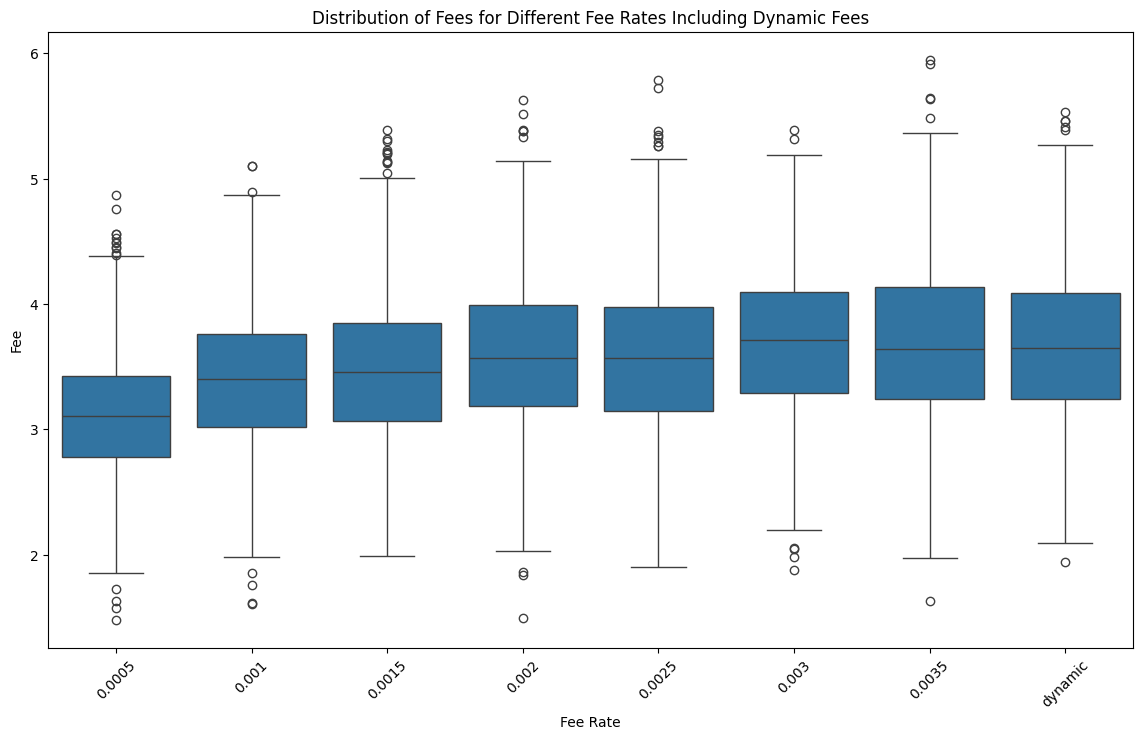

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# File paths
dynamic_result = pd.read_csv('/home/shiftpub/AMM-Python/results/dummy_results/dynamic_simulation_results_20241009_163710.csv')
static_result = pd.read_csv('/home/shiftpub/AMM-Python/results/dummy_results/static_simulation_results_20241009_162927.csv')

# Add a new column to identify dynamic fees
dynamic_result['fee_rate'] = 'dynamic'

# extract statis result for fee_rate <=0.35
# static_result = static_result[static_result['fee_rate'] <= 0.0035]
# Combine the two DataFrames
combined_results = pd.concat([static_result, dynamic_result], ignore_index=True)
# Set up the figure
plt.figure(figsize=(14, 8))

# Draw the boxplot with dynamic fees included
sns.boxplot(x='fee_rate', y='fee', data=combined_results)

# Rotate the x-axis labels
plt.xticks(rotation=45)

# Set the labels and title
plt.xlabel('Fee Rate')
plt.ylabel('Fee')
plt.title('Distribution of Fees for Different Fee Rates Including Dynamic Fees')

# Show the plot
plt.show()


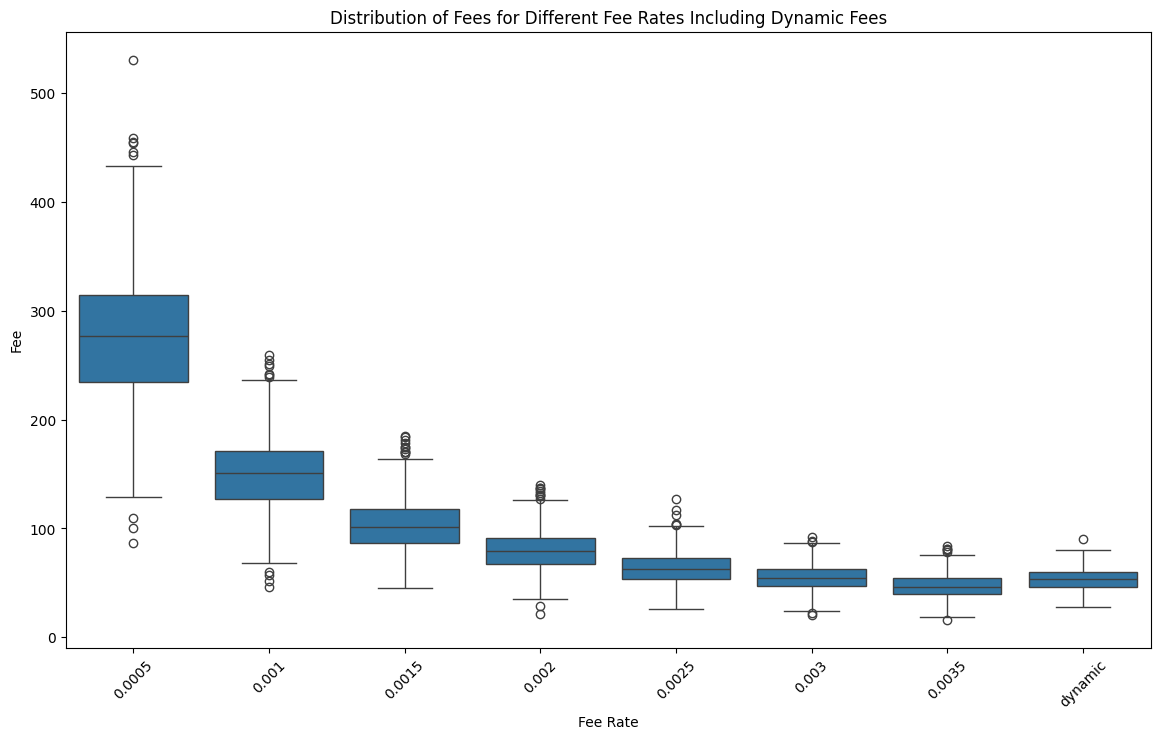

In [4]:
# Set up the figure
plt.figure(figsize=(14, 8))

# Draw the boxplot with dynamic fees included
sns.boxplot(x='fee_rate', y='pnl', data=combined_results)

# Rotate the x-axis labels
plt.xticks(rotation=45)

# Set the labels and title
plt.xlabel('Fee Rate')
plt.ylabel('Fee')
plt.title('Distribution of Fees for Different Fee Rates Including Dynamic Fees')

# Show the plot
plt.show()
